# Marketing project

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Необходимо выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.

Целевая метрика - `ROC_AUC`.

In [1]:
from IPython.display import clear_output

In [2]:
%pip install -r requirements.txt

clear_output()

In [3]:
!pip install catboost -q
!pip install lightgbm -q
!pip install phik -q

Сделаем импорты

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import (BaseEstimator,
                          TransformerMixin)

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Hyperparams tuning
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score)
from hyperopt import (hp,
                      fmin,
                      tpe,
                      Trials,
                      STATUS_OK)

# Metrics
from sklearn.metrics import (classification_report,
                            ConfusionMatrixDisplay,
                             roc_auc_score)

from phik import phik_matrix  # this import IS accessed
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

Создадим конфиг

In [5]:
RANDOM_STATE = 27
TEST_SIZE = 0.20

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

Далее импортируем сервисные функции для оптимизации

In [6]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    """Function optimizes memory usage in dataframe

    Args:
        df (pd.DataFrame): DataFrame to optimize.
        print_size (bool, optional): display of optimization results. Defaults to True.

    Returns:
        pd.DataFrame: optimized DataFrame
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию

    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024 ** 2

    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024 ** 2
    if print_size:
        print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [7]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
    else:
        duplicates_part = duplicates_count / len(df)
        print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [8]:
def check_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [9]:
def check_nans_in_series(series: pd.Series) -> None:
    nan_cnt = series.isna().sum()
    text = colored('No missing values', 'green') if nan_cnt == 0 \
        else colored(f'{nan_cnt} ({nan_cnt / len(series):.2%})', 'red')
    print(text)

In [10]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] =series.value_counts(normalize=True)
    display(data)

In [11]:
def plot_pie_chart(series: pd.Series) -> None:
    if not isinstance(series, pd.Series):
        raise ValueError('Входные данные должны быть объектом pd.Series')

    data = series.value_counts()

    plt.figure(figsize=(4, 4), facecolor='black')  # Устанавливаем черный фон
    data.plot.pie(labels=data.index, autopct='%1.1f%%', startangle=140,
                   colormap='spring')  # Используем кислотные тона
    plt.ylabel('')
    plt.title('Распределение данных', color='white')  # Заголовок белым цветом
    plt.axis('equal')
    plt.tight_layout()

    # Изменяем цвет текста на белый
    for text in plt.gca().texts:
        text.set_color('white')

    plt.show()

In [12]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    # Установка стиля и фона
    plt.style.use('dark_background')
    plt.figure(facecolor='black')

    # Создание подграфиков
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), facecolor='black')

    # Настройка цветовой палитры
    sns.set_palette("bright")

    # Визуализация графиков
    sns.violinplot(df, x=column, ax=ax1, orient='h', color='lime')
    ax1.set_xlabel(column_description, color='white')
    ax1.grid(color='gray')

    sns.boxplot(df, x=column, ax=ax2, color='cyan')
    ax2.set_xlabel(column_description, color='white')
    ax2.grid(color='gray')

    sns.histplot(df, x=column, bins=bins, ax=ax3, color='magenta')
    ax3.set_xlabel(column_description, color='white')
    ax3.set_ylabel('Количество', color='white')
    ax3.grid(color='gray')

    ax4.set_visible(False)

    # Настройка заголовка
    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18, color='white')
    plt.tight_layout()

    plt.show()

### Importing data

In [14]:
apparel_messages = pd.read_csv('apparel-messages.csv', parse_dates=['date', 'created_at'])

In [15]:
apparel_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [16]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


Чекнули типы данных, удостоверились, что все корректны. Сделаем оптимизацию памяти для нашего датасета6 применив функцию

In [17]:
apparel_messages = optimize_memory_usage(apparel_messages)

Размер использования памяти: до 680.38 Mb - после 607.48 Mb (10.7%)


Теперь проверим дубли также сервисной функцией

In [18]:
check_duplicates(apparel_messages)

Обнаружено 48610 дубликатов (0.38%)


достаточно много дублей, дропнем их

In [19]:
apparel_messages = apparel_messages.drop_duplicates()

In [20]:
check_nans(apparel_messages)

+------------------+----------------------+
|     Feature      | Missing values count |
+------------------+----------------------+
| bulk_campaign_id |      0 (0.00%)       |
|    client_id     |      0 (0.00%)       |
|    message_id    |      0 (0.00%)       |
|      event       |      0 (0.00%)       |
|     channel      |      0 (0.00%)       |
|       date       |      0 (0.00%)       |
|    created_at    |      0 (0.00%)       |
+------------------+----------------------+


Пропусков в датасете нет

Теперь посмотрим признаковые описания

In [21]:
apparel_messages['bulk_campaign_id']

0            4439
1            4439
2            4439
3            4439
4            4439
            ...  
12739793    14657
12739794    14657
12739795    14641
12739796    14624
12739797    14641
Name: bulk_campaign_id, Length: 12691188, dtype: int16

In [22]:
apparel_messages['bulk_campaign_id'].nunique()

2709

Столбец по документации является идентификатором рассылки и может быть использован при объединении датасетов

In [23]:
apparel_messages['client_id'].nunique()

53329

Этот столбец отвечает за идентификаторы клиента и также может быть использован при объединении

In [24]:
apparel_messages['message_id']

0            1515915625626736623-4439-6283415ac07ea
1            1515915625490086521-4439-62834150016dd
2            1515915625553578558-4439-6283415b36b4f
3            1515915625553578558-4439-6283415b36b4f
4            1515915625471518311-4439-628341570c133
                             ...                   
12739793    1515915625477497874-14657-65cdd371cc86c
12739794    1515915625765994334-14657-65cdd36018eac
12739795    1515915625545014677-14641-65cb2434b25a1
12739796    1515915625477497874-14624-65c5e22fb401e
12739797    1515915625477497874-14641-65cb249172d68
Name: message_id, Length: 12691188, dtype: object

In [25]:
apparel_messages['message_id'].nunique(), len(apparel_messages)

(9061667, 12691188)

Данный столбец является идентификатор сообщения. И состоит из 3 частей: id клиента (`client_id`), id рекламной компании (`bulk_campaign_id`) и (как я понимаю) непосредственно id сообщения.

In [26]:
apparel_messages['event']

0            open
1            open
2            open
3           click
4            open
            ...  
12739793     open
12739794     open
12739795     open
12739796     open
12739797     open
Name: event, Length: 12691188, dtype: object

In [27]:
apparel_messages.groupby('message_id')['event'].count().sort_values(ascending=False)[:5]

message_id
1515915625489095763-6251-6311b13a4cf78    1427
1515915625490241385-6973-633edf70723d8     438
1515915625490540122-6973-633edf707840d     438
1515915625629509124-6374-63241bd1541d5     286
1515915625488270582-3433-6232d6007e929     249
Name: event, dtype: int64

Можно заметить, что для одного сообщения указаны все действия, происходящие с ним. Посмотрим подробнее.

In [28]:
mask = apparel_messages['message_id'] == '1515915625489095763-6251-6311b13a4cf78'
apparel_messages[mask]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
1382528,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,send,email,2022-09-02,2022-09-02 07:46:54
1382934,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-02,2022-09-02 07:47:57
1402865,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,open,email,2022-09-02,2022-09-02 21:32:47
1402869,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2022-09-02,2022-09-02 21:35:41
1402872,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2022-09-02,2022-09-02 21:38:42
...,...,...,...,...,...,...,...
10209829,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2023-12-10,2023-12-10 17:09:30
11491461,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2024-01-11,2024-01-11 15:53:46
11778523,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2024-01-20,2024-01-20 15:32:08
11778530,6251,1515915625489095763,1515915625489095763-6251-6311b13a4cf78,click,email,2024-01-20,2024-01-20 15:34:08


Видно, что один клиент открывал одно и тоже письмо и кликал по нему большое количество раз. В будущем сгруппируем эти данные и сгенерируем на основе этого новые признаки.

In [29]:
apparel_messages['event'].nunique()

11

In [30]:
get_value_counts(apparel_messages['event'])

,count,part
event,,
send,9058174,0.71
open,3052481,0.24
click,483326,0.04
purchase,62593,0.00
hard_bounce,19763,0.00
soft_bounce,10582,0.00
unsubscribe,2833,0.00
hbq_spam,823,0.00
complain,527,0.00


Разберемся подробнее со статусами:

|     Статус     | Пояснение                            |
|:--------------:|--------------------------------------|
|   `send`       | Письмо или пуш отправлены            |
|   `open`       | Письмо или пуш открыты               |
|   `click`      | Совершен клик по ссылке              |
|   `purchase`   | Совершена покупка                    |
| `hard_bounce`  | Письмо не доставлено (жесткий отказ) |
| `soft_bounce`  | Письмо не доставлено (мягкий отказ)  |
| `unsubscribe`  | Пользователь отписался               |
|  `hbq_spam`    | Письмо помечено как спам             |
|   `complain`   | Получена жалоба от пользователя      |
|  `subscribe`   | Пользователь подписался              |
|    `close`     | Операция завершена (письмо закрыто?) |

In [31]:
apparel_messages['channel']

0           email
1           email
2           email
3           email
4           email
            ...  
12739793    email
12739794    email
12739795    email
12739796    email
12739797    email
Name: channel, Length: 12691188, dtype: object

In [32]:
apparel_messages['channel'].nunique()

2

In [33]:
get_value_counts(apparel_messages['channel'])

,count,part
channel,,
mobile_push,7470472,0.59
email,5220716,0.41


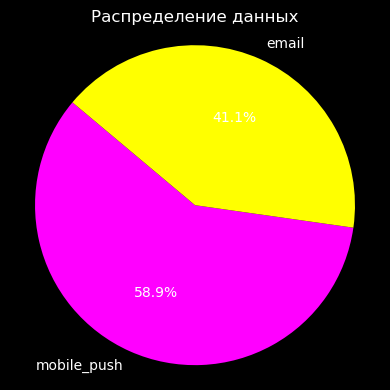

In [34]:
plot_pie_chart(apparel_messages['channel'])

In [35]:
apparel_messages['date']

0          2022-05-19
1          2022-05-19
2          2022-05-19
3          2022-05-19
4          2022-05-19
              ...    
12739793   2024-02-15
12739794   2024-02-15
12739795   2024-02-15
12739796   2024-02-15
12739797   2024-02-15
Name: date, Length: 12691188, dtype: datetime64[ns]

In [36]:
apparel_messages['date'].describe()

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object

здесь все даты представлены правильно

In [37]:
apparel_messages['created_at']

0          2022-05-19 00:14:20
1          2022-05-19 00:39:34
2          2022-05-19 00:51:49
3          2022-05-19 00:52:20
4          2022-05-19 00:56:52
                   ...        
12739793   2024-02-15 23:51:40
12739794   2024-02-15 23:52:20
12739795   2024-02-15 23:52:40
12739796   2024-02-15 23:58:40
12739797   2024-02-15 23:58:40
Name: created_at, Length: 12691188, dtype: datetime64[ns]

In [38]:
apparel_messages['created_at'].describe()

count                         12691188
mean     2023-06-05 04:38:55.658559232
min                2022-05-19 00:14:20
25%                2022-12-16 19:15:55
50%                2023-07-20 11:09:42
75%                2023-11-21 15:58:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object

In [39]:
mask = (apparel_messages['date'].dt.year != apparel_messages['created_at'].dt.year) | \
       (apparel_messages['date'].dt.month != apparel_messages['created_at'].dt.month) | \
       (apparel_messages['date'].dt.day != apparel_messages['created_at'].dt.day)
mask.sum()

0

Признак `created_at` содержит более полную информацию о дате рассылки, чем `date`, так содержит те же самые даты, но еще и время. По сути признак `created_at` включает в себя информацию столбца `date`, следовательно последний может быть удален.

In [40]:
shape_before = apparel_messages.shape
apparel_messages = apparel_messages.drop(columns='date')

assert apparel_messages.shape[0] == shape_before[0], 'Количество строк ДО и ПОСЛЕ удаления не совпадает.'
assert 'date' not in apparel_messages.columns, 'Признак не был удален.'
assert apparel_messages.shape[1] == shape_before[1] - 1, 'Количество признаков не совпадает с ожидаемым.'

Датасет содержит данные о рассылках, которые были отправлены клиентам из таблицы покупок. Содержит несколько id (`client_id`, `message_id`), которые будут использованы для объединения с другими таблицами.

Пропусков в датасете нет, полные дубликаты были обнаружены (`48610 (0.38%)`) и удалены.

Было замечено, что признак `created_at` содержит более полную информацию о дате рассылки, чем `date`, так содержит те же самые даты, но еще время. По сути признак `created_at` включает в себя информацию столбца `date`. Поэтому признак `date` был удален.

Теперь посмотрим другой датасет - `apparel_purchases`

In [43]:
apparel_purchases = pd.read_csv('apparel-purchases.csv', parse_dates=['date'])

In [44]:
apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [45]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


с типами данных и отображением проблем нет

In [46]:
apparel_purchases = optimize_memory_usage(apparel_purchases)

Размер использования памяти: до  9.26 Mb - после  7.14 Mb (22.9%)


In [47]:
check_duplicates(apparel_purchases)

Обнаружено 73020 дубликатов (36.11%)


Обнаружено довольно большое количество полных дубликатов (больше `36%`). Это выглядит довольно странно.

Что значит, что строки полные дубликаты между собой? Что пользователь купил в один день один по одной рассылке товары с одной ценой из одной категории. Скорее всего это значит, что пользователь купил разные вкусы или оформил один и тот же товар разными заказами. Например, купил товар, подумал, что надо бы еще купить сразу прозапас. И вновь купил этот же товар.

Поэтому самым логичным решением кажется сгруппировать эти строки, просуммировав признак `quantity`.

In [48]:
other_columns = apparel_purchases.columns.difference(['quantity']).tolist()
apparel_purchases = apparel_purchases.groupby(other_columns, as_index=False).agg({'quantity': 'sum'})

In [49]:
check_duplicates(apparel_purchases)

Полных дубликатов не обнаружено.


In [50]:
check_nans(apparel_purchases)

+--------------+----------------------+
|   Feature    | Missing values count |
+--------------+----------------------+
| category_ids |      0 (0.00%)       |
|  client_id   |      0 (0.00%)       |
|     date     |      0 (0.00%)       |
|  message_id  |      0 (0.00%)       |
|    price     |      0 (0.00%)       |
|   quantity   |      0 (0.00%)       |
+--------------+----------------------+


далее изучим признаки

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например, автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

**Признаки:**
|     Признак    | Описание                            |
|:--------------:|-------------------------------------|
|   `client_id`  | идентификатор клиента               |
|   `quantity`   | количество единиц товара            |
|     `price`    | цена товара                         |
| `category_ids` | идентификаторы категорий            |
|     `date`     | дата покупки                        |
|  `message_id`  | идентификатор сообщения из рассылки |

In [51]:
apparel_purchases['client_id']

0         1515915625489044168
1         1515915625789566616
2         1515915625666901395
3         1515915625468069875
4         1515915625468124765
                 ...         
129013    1515915626009515678
129014    1515915626009608336
129015    1515915626009661190
129016    1515915626009681249
129017    1515915626010183608
Name: client_id, Length: 129018, dtype: int64

In [52]:
apparel_purchases['client_id'].nunique()

49849

Данный столбец содержит идентификаторы клиентов и может быть использован при объединении таблиц.

In [53]:
apparel_purchases['quantity']

0         1
1         1
2         1
3         1
4         1
         ..
129013    2
129014    2
129015    2
129016    2
129017    2
Name: quantity, Length: 129018, dtype: int8

In [54]:
apparel_purchases['quantity'].nunique()

35

In [55]:
apparel_purchases['quantity'].describe()

count   129018.00
mean         1.58
std          0.99
min          1.00
25%          1.00
50%          1.00
75%          2.00
max         96.00
Name: quantity, dtype: float64

In [56]:
get_value_counts(apparel_purchases['quantity'])

,count,part
quantity,,
1,69620,0.54
2,52277,0.41
4,3038,0.02
3,2930,0.02
6,508,0.00
5,312,0.00
8,87,0.00
7,69,0.00
10,44,0.00


<Figure size 640x480 with 0 Axes>

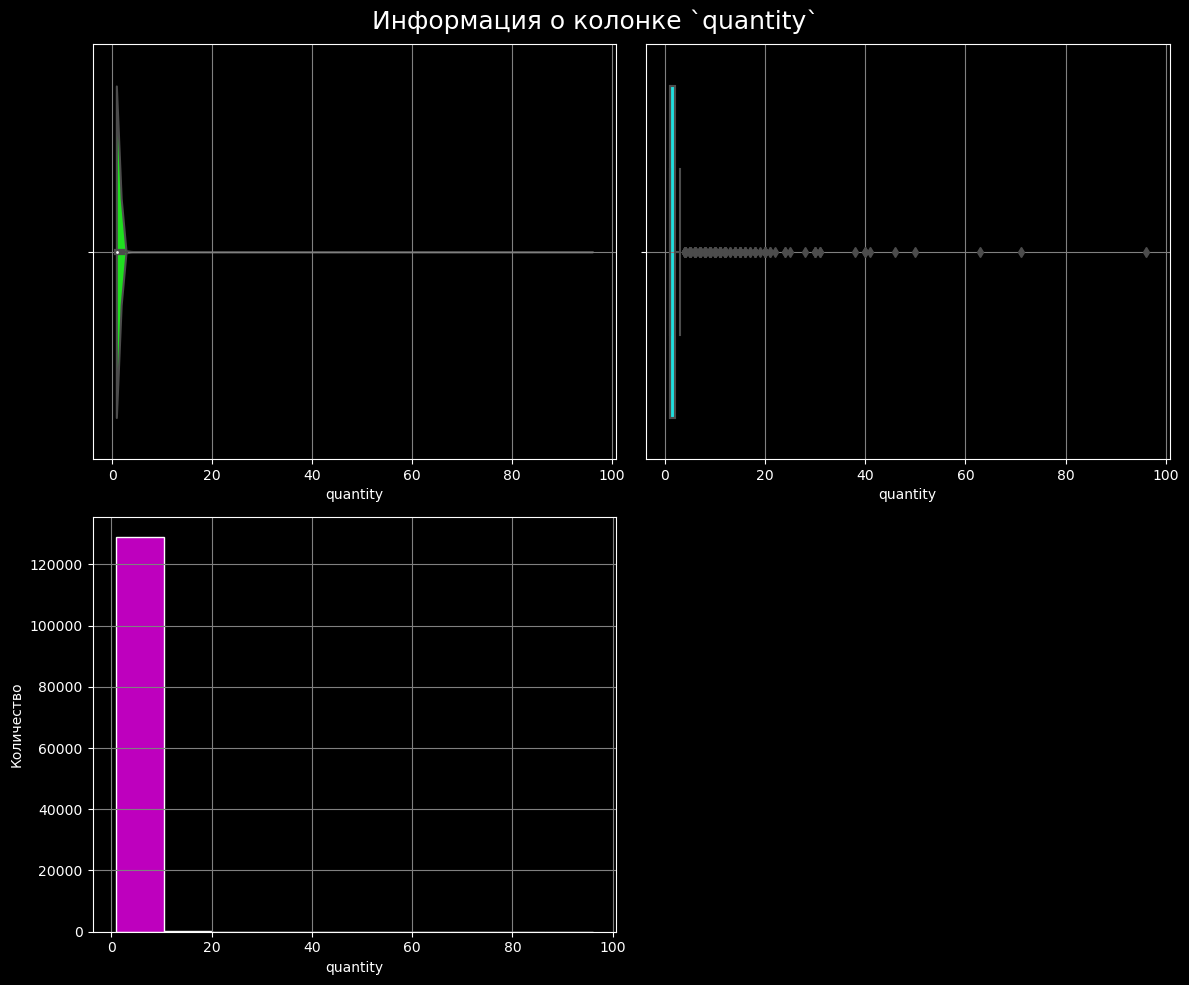

In [57]:
draw_plots_about_column(apparel_purchases, 'quantity', bins=10)

In [58]:
apparel_purchases['price']

0        1799.00
1        1799.00
2         199.00
3         999.00
4         999.00
           ...  
129013      7.00
129014      7.00
129015      5.00
129016      7.00
129017      5.00
Name: price, Length: 129018, dtype: float32

In [59]:
apparel_purchases['price'].describe()

count   129018.00
mean      1264.69
std       1375.35
min          1.00
25%        399.00
50%        999.00
75%       1750.00
max      85499.00
Name: price, dtype: float64

<Figure size 640x480 with 0 Axes>

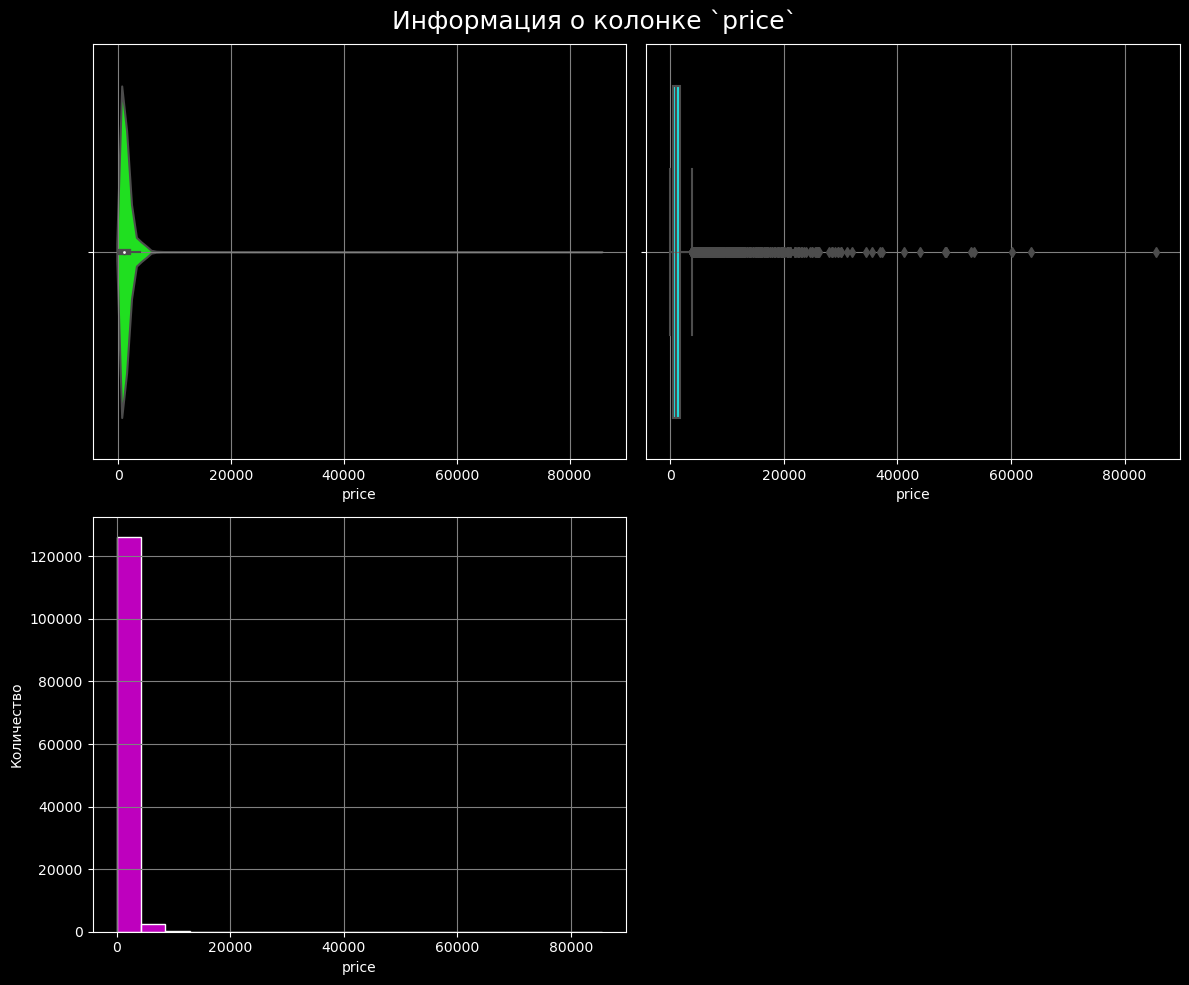

In [60]:
draw_plots_about_column(apparel_purchases, 'price')

In [61]:
apparel_purchases['category_ids']

0          ['1', '22', '50', '685']
1          ['1', '22', '50', '685']
2          ['1', '8', '280', '710']
3         ['2', '17', '107', '453']
4         ['2', '17', '107', '453']
                    ...            
129013                           []
129014                           []
129015                           []
129016                           []
129017                           []
Name: category_ids, Length: 129018, dtype: object

In [62]:
apparel_purchases['category_ids'].unique()

array(["['1', '22', '50', '685']", "['1', '8', '280', '710']",
       "['2', '17', '107', '453']", "['2', '17', '137', '469']",
       "['2', '17', '171', '475']", "['2', '17', '173', '1598']",
       "['2', '17', '173', '1845']", "['2', '17', '173', '459']",
       "['2', '17', '180', '465']", "['2', '17', '1826', '1818']",
       "['2', '17', '188', '525']", "['2', '17', '198', '497']",
       "['2', '17', '232', '463']", "['2', '17', '279', '5807']",
       "['2', '17', '286', '455']", "['2', '17', '293', '5819']",
       "['2', '17', '330', '387', '467']", "['2', '17', '83', '519']",
       "['2', '17', '83', '5810']", "['2', '18', '123', '451']",
       "['2', '18', '155', '1325']", "['2', '18', '155', '439']",
       "['2', '18', '212', '658']", "['2', '18', '212', '659']",
       "['2', '18', '212', '726']", "['2', '18', '217', '662']",
       "['2', '18', '217', '663']", "['2', '18', '243', '440']",
       "['2', '18', '248', '449']", "['2', '18', '248', '677']",
       "['2', 

В задании было указано, что

> Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можете предлагать свои варианты решения.

In [63]:
apparel_purchases['date']

0        2022-07-12
1        2022-08-07
2        2022-06-01
3        2022-07-09
4        2022-07-08
            ...    
129013   2024-02-03
129014   2024-02-06
129015   2024-02-07
129016   2024-02-05
129017   2024-02-13
Name: date, Length: 129018, dtype: datetime64[ns]

In [64]:
apparel_purchases['date'].describe()

count                           129018
mean     2023-02-26 10:13:27.292005632
min                2022-05-16 00:00:00
25%                2022-09-09 00:00:00
50%                2023-03-22 00:00:00
75%                2023-06-28 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

представления дат адекватны

In [65]:
apparel_purchases['message_id']

0          1515915625489044168-5335-62c7d2d6bd056
1          1515915625789566616-5785-62ecc38c85606
2          1515915625666901395-4698-62971583c7270
3          1515915625487285028-5335-62c7d2b9eef22
4          1515915625468124765-5335-62c7d2d245db8
                           ...                   
129013    1515915625776547382-14587-65bcc2a78a468
129014    1515915626009608336-14594-65c0879eaf1ec
129015    1515915626009661190-14600-65c1e75b31a21
129016    1515915625558930991-14595-65c085673111d
129017    1515915625489302721-14623-65c5c5804cb67
Name: message_id, Length: 129018, dtype: object

Значения в данном столбце состоят из 3 частей: id клиента (`client_id`), id рекламной компании (`bulk_campaign_id`) и (как я понимаю) непосредственно id сообщения.

Данный датасет содержит данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

Было обнаружено довольно много полных дубликатов - `73020 (36%)`. В итоге было принято решение, сгруппировать такие записи, просуммировав количество (признак `quantity`). После проведенного преобразования полных дубликатов больше нет.

Пропусков в датасете нет.

Перейдём к исследованию следующего датасета

In [67]:
apparel_target_binary = pd.read_csv('apparel-target_binary.csv')

In [68]:
apparel_target_binary.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [69]:
apparel_target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Общая информация о данных корректна

In [70]:
apparel_target_binary = optimize_memory_usage(apparel_target_binary)

Размер использования памяти: до  0.76 Mb - после  0.43 Mb (43.7%)


In [71]:
check_duplicates(apparel_target_binary)

Полных дубликатов не обнаружено.


In [72]:
check_nans(apparel_target_binary)

+-----------+----------------------+
|  Feature  | Missing values count |
+-----------+----------------------+
| client_id |      0 (0.00%)       |
|   target  |      0 (0.00%)       |
+-----------+----------------------+


Далее посмотрим признаки

In [73]:
apparel_target_binary['client_id']

0        1515915625468060902
1        1515915625468061003
2        1515915625468061099
3        1515915625468061100
4        1515915625468061170
                ...         
49844    1515915626010261344
49845    1515915626010266132
49846    1515915626010439406
49847    1515915626010443527
49848    1515915626010443624
Name: client_id, Length: 49849, dtype: int64

In [74]:
apparel_target_binary['client_id'].nunique(), len(apparel_target_binary)

(49849, 49849)

все id уникальны

In [75]:
get_value_counts(apparel_target_binary['target'])

,count,part
target,,
0,48888,0.98
1,961,0.02


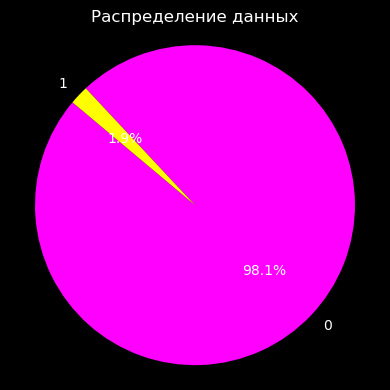

In [76]:
plot_pie_chart(apparel_target_binary['target'])

Видим крайне сильный дизбаланс в сторону класса `0`.

Датасет содержит информацию о целевом признаке - совершил ли клиент покупку в целевом периоде.

В датасете всего 2 столбца:
- `client_id` - идентификатор клиента, который будет использован для объединения таблиц
- `target` - целевой признак

Пропусков в датасете нет, полные дубликаты не обнаружены.

Далее преобразуем датафрейм `apparel_messages`

In [77]:
apparel_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19 00:56:52


создадим аггрегированный датафрейм

In [78]:
aggregated_df = apparel_messages.groupby(['client_id', 'channel', 'event']).size().reset_index(name='count')
apparel_messages_agg = aggregated_df.pivot_table(index='client_id', columns=['channel', 'event'], values='count', fill_value=0)
apparel_messages_agg.columns = [f'{channel}_{event}_cnt' for channel, event in apparel_messages_agg.columns]
apparel_messages_agg.head()

,email_click_cnt,email_complain_cnt,email_hard_bounce_cnt,email_hbq_spam_cnt,email_open_cnt,email_purchase_cnt,email_send_cnt,email_soft_bounce_cnt,email_subscribe_cnt,email_unsubscribe_cnt,mobile_push_click_cnt,mobile_push_close_cnt,mobile_push_hard_bounce_cnt,mobile_push_open_cnt,mobile_push_purchase_cnt,mobile_push_send_cnt,mobile_push_soft_bounce_cnt
client_id,,,,,,,,,,,,,,,,,
1515915625468060902,10,0,0,0,35,5,126,0,0,1,0,0,0,0,0,0,0
1515915625468061003,5,0,0,0,5,1,154,0,0,0,0,0,0,0,0,0,0
1515915625468061099,8,0,0,0,17,0,157,0,0,0,0,0,2,34,0,58,0
1515915625468061100,0,0,0,0,0,0,0,0,0,0,1,0,1,157,1,267,1
1515915625468061170,16,0,0,0,19,3,164,0,0,0,0,0,0,12,0,79,0


далее преобразуем `apparel_purchases`

In [79]:
apparel_purchases.head()

,category_ids,client_id,date,message_id,price,quantity
0,"['1', '22', '50', '685']",1515915625489044168,2022-07-12,1515915625489044168-5335-62c7d2d6bd056,1799.00,1
1,"['1', '22', '50', '685']",1515915625789566616,2022-08-07,1515915625789566616-5785-62ecc38c85606,1799.00,1
2,"['1', '8', '280', '710']",1515915625666901395,2022-06-01,1515915625666901395-4698-62971583c7270,199.00,1
3,"['2', '17', '107', '453']",1515915625468069875,2022-07-09,1515915625487285028-5335-62c7d2b9eef22,999.00,1
4,"['2', '17', '107', '453']",1515915625468124765,2022-07-08,1515915625468124765-5335-62c7d2d245db8,999.00,1


In [80]:
len(apparel_purchases), apparel_purchases['client_id'].nunique(), apparel_purchases['message_id'].nunique()

(129018, 49849, 50204)

In [81]:
apparel_purchases['subtotal'] = apparel_purchases['price'] * apparel_purchases['quantity']

In [82]:
apparel_purchases_agg = pd.DataFrame(index=apparel_purchases['client_id'].unique())

In [83]:
apparel_purchases_agg['total'] = apparel_purchases.groupby('client_id')['subtotal'].sum()

In [84]:
apparel_purchases_agg.head()

,total
1515915625489044168,3996.00
1515915625789566616,3198.00
1515915625666901395,36235.00
1515915625468069875,1397.00
1515915625468124765,999.00


In [85]:
assert len(apparel_purchases_agg) == apparel_purchases['client_id'].nunique(),\
    'Количество ID сообщений не совпадает в общей и агрегированной таблицах'

### Объединение датафреймов

In [86]:
apparel_target_binary.sort_index().head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [87]:
apparel_purchases_agg.sort_index().head()

,total
1515915625468060902,6993.00
1515915625468061003,16235.00
1515915625468061099,299.00
1515915625468061100,2098.00
1515915625468061170,33601.00


In [88]:
assert len(apparel_target_binary) == len(apparel_purchases_agg),\
    'Количество ID клиентов не совпадает (или есть дубликаты)'

In [89]:
df = pd.merge(apparel_target_binary, apparel_purchases_agg, how='left', left_on='client_id', right_index=True)
df.head()

,client_id,target,total
0,1515915625468060902,0,6993.00
1,1515915625468061003,1,16235.00
2,1515915625468061099,0,299.00
3,1515915625468061100,0,2098.00
4,1515915625468061170,0,33601.00


In [90]:
apparel_messages_agg.head()

,email_click_cnt,email_complain_cnt,email_hard_bounce_cnt,email_hbq_spam_cnt,email_open_cnt,email_purchase_cnt,email_send_cnt,email_soft_bounce_cnt,email_subscribe_cnt,email_unsubscribe_cnt,mobile_push_click_cnt,mobile_push_close_cnt,mobile_push_hard_bounce_cnt,mobile_push_open_cnt,mobile_push_purchase_cnt,mobile_push_send_cnt,mobile_push_soft_bounce_cnt
client_id,,,,,,,,,,,,,,,,,
1515915625468060902,10,0,0,0,35,5,126,0,0,1,0,0,0,0,0,0,0
1515915625468061003,5,0,0,0,5,1,154,0,0,0,0,0,0,0,0,0,0
1515915625468061099,8,0,0,0,17,0,157,0,0,0,0,0,2,34,0,58,0
1515915625468061100,0,0,0,0,0,0,0,0,0,0,1,0,1,157,1,267,1
1515915625468061170,16,0,0,0,19,3,164,0,0,0,0,0,0,12,0,79,0


In [91]:
df = pd.merge(df, apparel_messages_agg, how='left', left_on='client_id', right_index=True)
df = df.set_index('client_id')
df.head()

,target,total,email_click_cnt,email_complain_cnt,email_hard_bounce_cnt,email_hbq_spam_cnt,email_open_cnt,email_purchase_cnt,email_send_cnt,email_soft_bounce_cnt,email_subscribe_cnt,email_unsubscribe_cnt,mobile_push_click_cnt,mobile_push_close_cnt,mobile_push_hard_bounce_cnt,mobile_push_open_cnt,mobile_push_purchase_cnt,mobile_push_send_cnt,mobile_push_soft_bounce_cnt
client_id,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,6993.00,10.00,0.00,0.00,0.00,35.00,5.00,126.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1515915625468061003,1,16235.00,5.00,0.00,0.00,0.00,5.00,1.00,154.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1515915625468061099,0,299.00,8.00,0.00,0.00,0.00,17.00,0.00,157.00,0.00,0.00,0.00,0.00,0.00,2.00,34.00,0.00,58.00,0.00
1515915625468061100,0,2098.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,157.00,1.00,267.00,1.00
1515915625468061170,0,33601.00,16.00,0.00,0.00,0.00,19.00,3.00,164.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,79.00,0.00


Далее проверим типы даннных после объединения

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   target                       49849 non-null  int8   
 1   total                        49849 non-null  float32
 2   email_click_cnt              41982 non-null  float64
 3   email_complain_cnt           41982 non-null  float64
 4   email_hard_bounce_cnt        41982 non-null  float64
 5   email_hbq_spam_cnt           41982 non-null  float64
 6   email_open_cnt               41982 non-null  float64
 7   email_purchase_cnt           41982 non-null  float64
 8   email_send_cnt               41982 non-null  float64
 9   email_soft_bounce_cnt        41982 non-null  float64
 10  email_subscribe_cnt          41982 non-null  float64
 11  email_unsubscribe_cnt        41982 non-null  float64
 12  mobile_push_click_cnt        41982 non-null  fl

In [93]:
mask = df['email_click_cnt'].isna()
na_ids = df.loc[mask].index.tolist()

In [94]:
mask = apparel_messages['client_id'].isin(na_ids)
apparel_messages[mask]

,bulk_campaign_id,client_id,message_id,event,channel,created_at


у этих пользователей рассылки не было, поэтому заполним нулями

In [95]:
df = df.fillna(0)

In [96]:
check_nans(df)

+-----------------------------+----------------------+
|           Feature           | Missing values count |
+-----------------------------+----------------------+
|            target           |      0 (0.00%)       |
|   mobile_push_purchase_cnt  |      0 (0.00%)       |
|     mobile_push_open_cnt    |      0 (0.00%)       |
| mobile_push_hard_bounce_cnt |      0 (0.00%)       |
|    mobile_push_close_cnt    |      0 (0.00%)       |
|    mobile_push_click_cnt    |      0 (0.00%)       |
|    email_unsubscribe_cnt    |      0 (0.00%)       |
|     email_subscribe_cnt     |      0 (0.00%)       |
|     mobile_push_send_cnt    |      0 (0.00%)       |
|    email_soft_bounce_cnt    |      0 (0.00%)       |
|      email_purchase_cnt     |      0 (0.00%)       |
|        email_open_cnt       |      0 (0.00%)       |
|      email_hbq_spam_cnt     |      0 (0.00%)       |
|    email_hard_bounce_cnt    |      0 (0.00%)       |
|      email_complain_cnt     |      0 (0.00%)       |
|       em

In [97]:
df = optimize_memory_usage(df)

Размер использования памяти: до  7.08 Mb - после  3.85 Mb (45.6%)


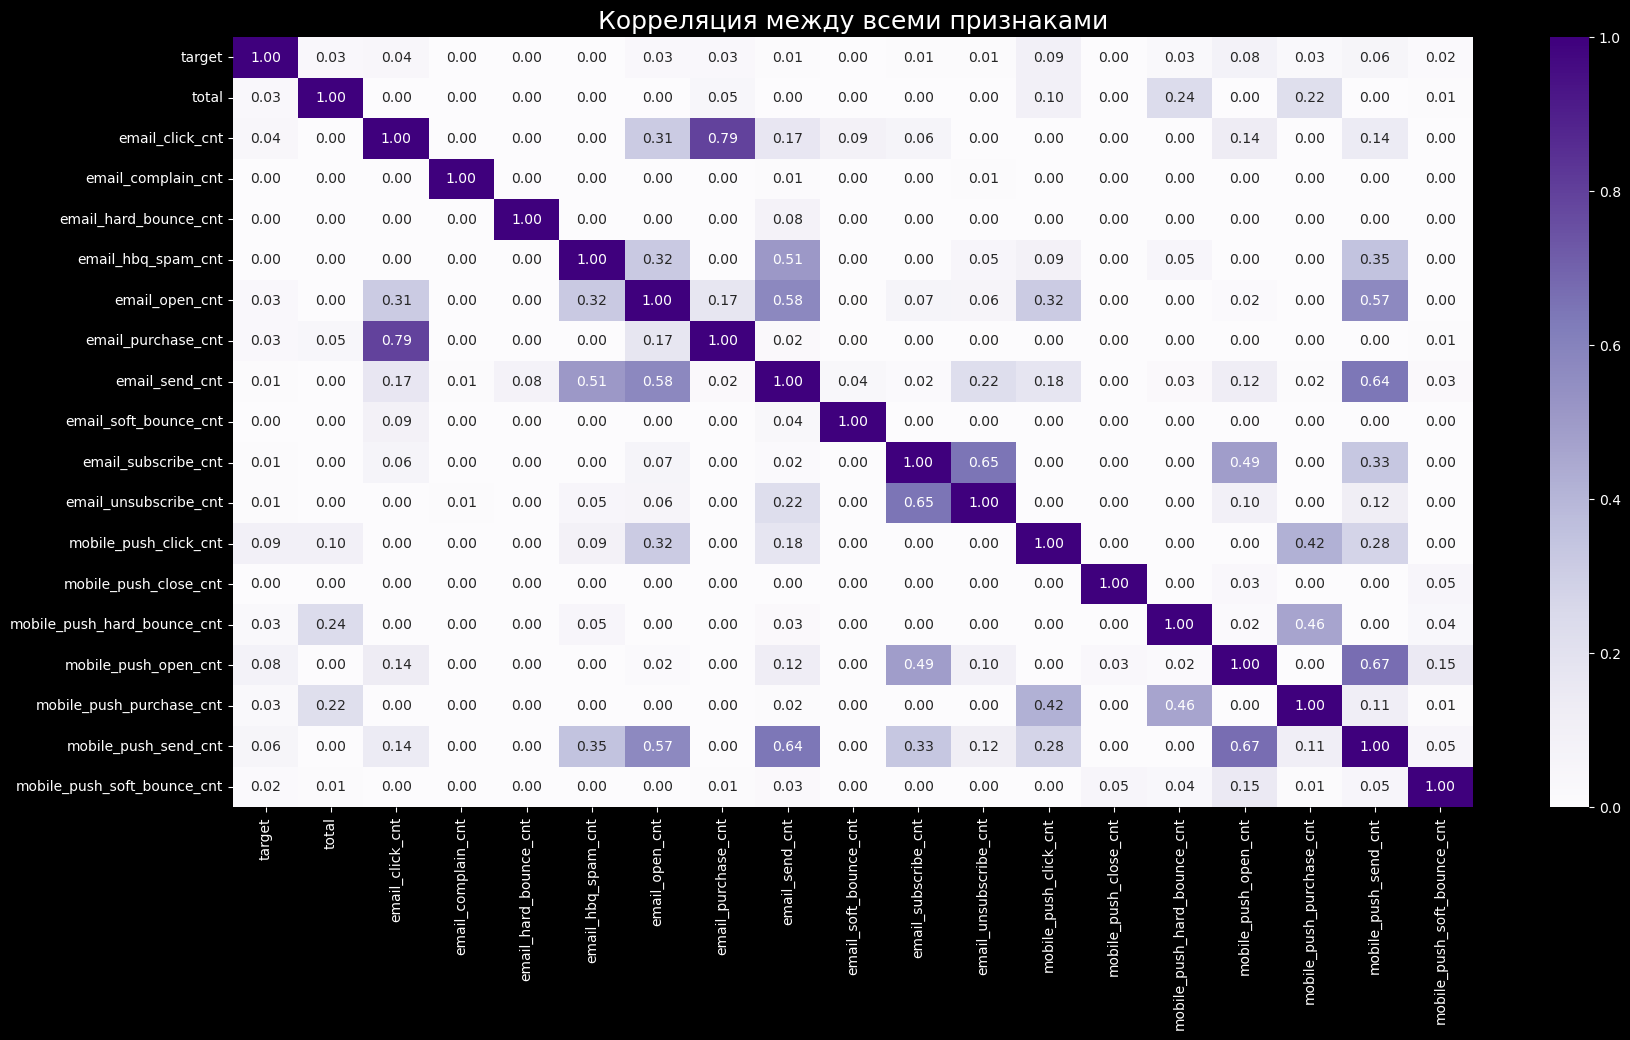

In [98]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.phik_matrix(interval_cols=df.columns),
            cmap='Purples',
            annot=True,
            fmt='.2f');

plt.title(r'Корреляция между всеми признаками', fontsize=18);

In [99]:
scaler = StandardScaler()
df_for_vif = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

with_constants = add_constant(df_for_vif)

vif_data = pd.DataFrame()
vif_data['variable'] = with_constants.columns
vif_data['vif'] = [variance_inflation_factor(with_constants.values, i) for i in range(with_constants.shape[1])]

vif_data.sort_values(by='vif', ascending=False).reset_index(drop=True)

,variable,vif
0,mobile_push_send_cnt,2.07
1,email_click_cnt,1.86
2,mobile_push_open_cnt,1.67
3,email_open_cnt,1.67
4,email_purchase_cnt,1.59
5,email_send_cnt,1.52
6,mobile_push_purchase_cnt,1.51
7,mobile_push_click_cnt,1.47
8,email_unsubscribe_cnt,1.11
9,email_subscribe_cnt,1.10


Исходя из анализа, мультиколлинеарности нет

### Data splitting and training

In [100]:
target = 'target'

In [101]:
X = df.drop(columns=target)
y = df[target]

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(39879, 18) (39879,)
(9970, 18) (9970,)


In [103]:
def get_objective(estimator,
                  X_train: pd.DataFrame,
                  y_train: pd.Series):
    def objective(params: dict) -> float:
        """Кросс-валидация с текущими гиперпараметрами.

        Args:
            estimator: пайплайн с моделью или отдельно модель
            params (dict): гиперпараметры
            X_train (pd.DataFrame): входные признаки (фичи)
            y_train (pd.Series): таргет

        Returns:
            dict: Словарь со средним значением метрики, гиперпараметрами и статусом.
        """
        # Некоторые параметры могут быть только целочисленные, приводим их к нужному типу
        for key, value in params.items():
            if isinstance(value, float) and value % 1 == 0:
                params[key] = int(value)

        estimator.set_params(**params)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        score = cross_val_score(estimator=estimator,
                                X=X_train,
                                y=y_train,
                                scoring='roc_auc',
                                cv=skf,
                                n_jobs=-1)

        return {
            'loss': -score.mean(),
            'params': params,
            'status': STATUS_OK
        }

    return objective

In [104]:
def get_model_results(estimator,
                      param_space: dict,
                      X_train: pd.DataFrame,
                      y_train: pd.Series
                      ) -> tuple[dict, float]:
    objective = get_objective(estimator, X_train, y_train)
    trials = Trials()

    fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE),
        show_progressbar=True
    )

    clear_output()

    best_params = trials.best_trial['result']['params']
    best_score = abs(trials.best_trial['result']['loss'])
    print(f"Finish with best ROC_AUC = {best_score:.4f}")

    return best_params, best_score

Log Reg

In [105]:
lr_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

param_space = {
    'model__penalty': hp.choice('penalty', ['l1', 'l2']),  # Тип регуляризации
    'model__C': hp.loguniform('C', -4, 4),  # Обратный коэффициент регуляризации
    'model__solver': hp.choice('solver', ['liblinear', 'saga']),  # Алгоритм оптимизации
    'model__fit_intercept': hp.choice('fit_intercept', [True, False]),  # Включение свободного члена
    'model__class_weight': hp.choice('class_weight', ['balanced', None]),  # Взвешивание классов
    'model__max_iter': hp.quniform('max_iter', 300, 1000, 50)  # Максимальное количество итераций
}

best_params_lr, best_score_lr = get_model_results(lr_pipeline, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6871


Random Forest

In [106]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'class_weight': hp.choice('class_weight', ['balanced', {0: 1, 1: 49}]),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

best_params_rfc, best_score_rfc = get_model_results(rfc, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6824


kneighbours

In [107]:
knc = KNeighborsClassifier(n_jobs=-1)

param_space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1),  # количество соседей
    'weights': hp.choice('weights', ['uniform', 'distance']),  # схема взвешивания
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  # алгоритм поиска
    'leaf_size': hp.quniform('leaf_size', 10, 50, 1),  # размер листа
    'p': hp.choice('p', [1, 2])  # степень метрики Минковского (1 = манхэттенское, 2 = евклидово расстояние)
}

best_params_knc, best_score_knc = get_model_results(knc, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.5530


LinearSVC

In [108]:
svc_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearSVC(random_state=RANDOM_STATE))
])

param_space = {
    'model__C': hp.loguniform('C', -4, 2),  # Регуляризационный параметр C в лог-шкале
    'model__loss': hp.choice('loss', ['hinge', 'squared_hinge']),
    'model__tol': hp.loguniform('tol', -5, -1),  # Допуск на остановку в лог-шкале
    'model__max_iter': hp.quniform('max_iter', 100, 1000, 50),  # Максимальное количество итераций
    'model__class_weight': hp.choice('class_weight', [None, 'balanced']),  # Взвешивание классов
}

best_params_svc, best_score_svc = get_model_results(svc_pipeline, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6861


CatBoost

In [110]:
cbc = CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, silent=True)

param_space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),  # число итераций
    'learning_rate': hp.loguniform('learning_rate', -5, -1),  # темп обучения
    'depth': hp.quniform('depth', 4, 10, 1),  # глубина деревьев
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 0, 3),  # L2 регуляризация
    'border_count': hp.quniform('border_count', 32, 255, 1),  # число разбиений
    'random_strength': hp.uniform('random_strength', 0, 10),  # сила случайности
    'scale_pos_weight': hp.loguniform('scale_pos_weight', -2, 2),  # вес положительных классов
    'bootstrap_type': hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),  # тип bootstrap
    'grow_policy': hp.choice('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),  # политика роста
}

best_params_cbc, best_score_cbc = get_model_results(cbc, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6918


LGBM

In [111]:
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)

param_space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 1),
    'scale_pos_weight': hp.loguniform('scale_pos_weight', -2, 1)  # Изменено для учета несбалансированных данных
}

best_params_lgbm, best_score_lgbm = get_model_results(lgbmc, param_space, X_train, y_train)

Finish with best ROC_AUC = 0.6911


### Результаты

In [112]:
pd.options.display.float_format = '{:.4f}'.format

pd.DataFrame(
    data=[best_score_lr, best_score_rfc, best_score_knc, best_score_svc, best_score_cbc, best_score_lgbm],
    index=['LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier', 'SVC', 'CatBoostClassifier', 'LGBMClassifier'],
    columns=['roc_auc']
).sort_values('roc_auc', ascending=False)

,roc_auc
CatBoostClassifier,0.6918
LGBMClassifier,0.6911
LogisticRegression,0.6871
SVC,0.6861
RandomForestClassifier,0.6824
KNeighborsClassifier,0.5530


метрика на тесте

In [113]:
# Некоторые параметры могут быть только целочисленные, приводим их к нужному типу
for key, value in best_params_cbc.items():
    if isinstance(value, float) and value % 1 == 0:
        best_params_cbc[key] = int(value)

In [114]:
best_params_cbc

{'bootstrap_type': 'Bayesian',
 'border_count': 200,
 'depth': 4,
 'grow_policy': 'SymmetricTree',
 'iterations': 900,
 'l2_leaf_reg': 4.218585731014478,
 'learning_rate': 0.02309380598609181,
 'random_strength': 1.3032420654857055,
 'scale_pos_weight': 2.255868943560115}

In [115]:
best_model = CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, silent=True, **best_params_cbc)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print(f'ROC_AUC to test = {roc_auc:.4f}')

ROC_AUC to test = 0.7245


In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9778
           1       0.00      0.00      0.00       192

    accuracy                           0.98      9970
   macro avg       0.49      0.50      0.50      9970
weighted avg       0.96      0.98      0.97      9970



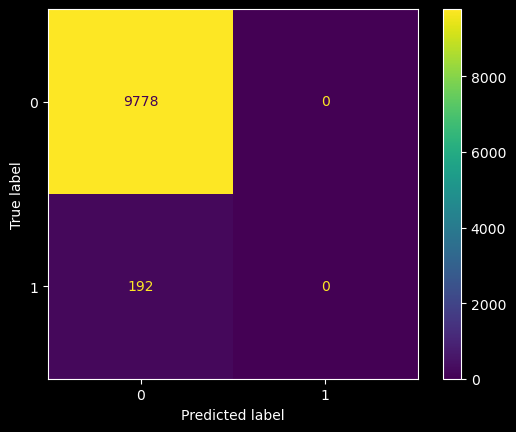

In [117]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

ВАЖНОСТЬ ПРИЗНАКОВ

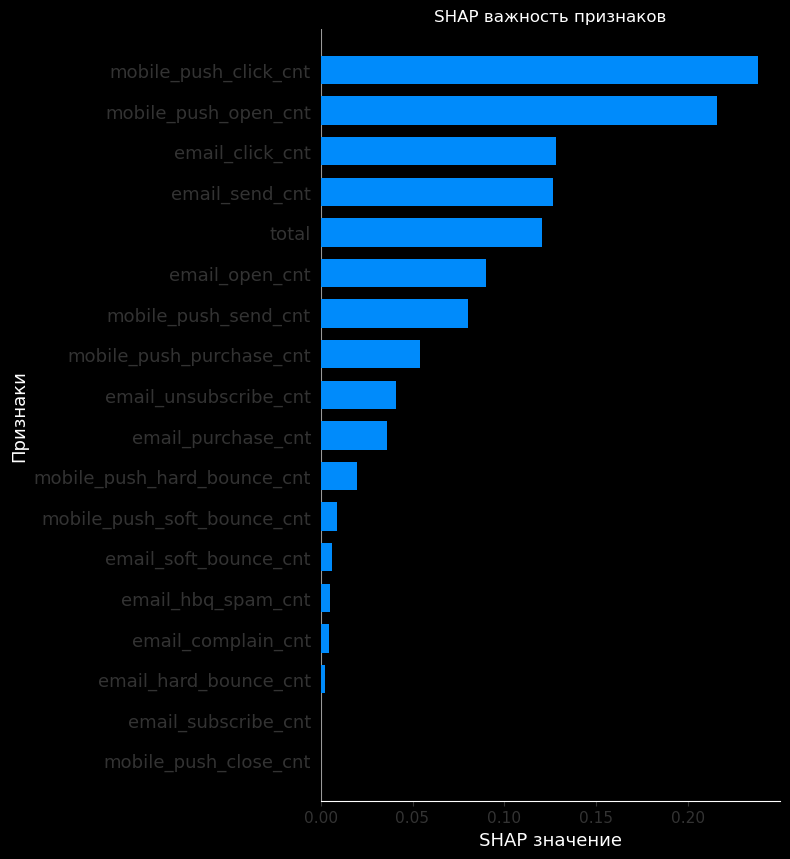

In [118]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values,
                  X_test,
                  color_bar_label='Признаки',
                  show=False,
                  plot_type='bar',
                  show_values_in_legend=True,
                  max_display=20)
plt.title('SHAP важность признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Признаки', fontsize=13)

plt.tight_layout()
plt.show()

В рамках данного проекта мы работали с различными датасетами с информацией о рассылках пользователям и их покупках. Нам было дано 3 основных датасета: apparel-messages, apparel_purchases и apparel-target-binary. Ни один из датасетов не содержит пропусков. Второй из них содержал незначительное количество полных дубликатов (0.38%). Они были удалены.

Далее датасеты были проагрегированы и объединены.

Было протестировано несколько различных моделей на трейн выборке с подбором гиперпараметров с помощью hyperopt. Лучше всего себя показала модель CatBoostClassifier с минимальным отрывом обогнав LGBMClassifier.

Однако модель вообще ни разу не поставила метку 0 (при пороге 0.5).